In [1]:
from xdesign import *
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import multiprocessing
import logging
import pickle
import os

# from TextMeWhenDone import textmewhendone

logger = logging.getLogger()
logger.setLevel(logging.INFO)

`polytope` failed to import `cvxopt.glpk`.
Will use `scipy.optimize.linprog`.


In [2]:
np.random.seed(0)
phantom = DogaCircles(n_sizes=7, size_ratio=10/16, n_shuffles=16)
phantom.radii

array([[ 0.01953,  0.00298,  0.03125,  0.01221,  0.00763,  0.05   ,
         0.00477],
       [ 0.05   ,  0.00763,  0.00298,  0.03125,  0.01953,  0.00477,
         0.01221],
       [ 0.01221,  0.05   ,  0.01953,  0.00763,  0.00477,  0.03125,
         0.00298],
       [ 0.00763,  0.03125,  0.01221,  0.00477,  0.00298,  0.01953,  0.05   ],
       [ 0.00298,  0.01221,  0.00477,  0.05   ,  0.03125,  0.00763,
         0.01953],
       [ 0.03125,  0.00477,  0.05   ,  0.01953,  0.01221,  0.00298,
         0.00763],
       [ 0.00477,  0.01953,  0.00763,  0.00298,  0.05   ,  0.01221,
         0.03125]])

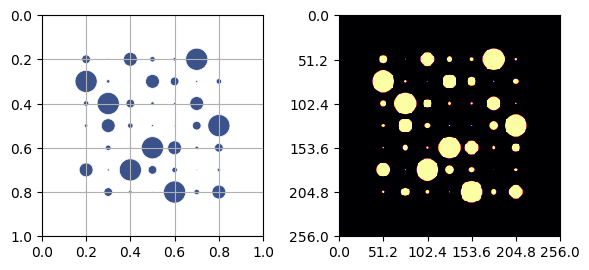

In [3]:
size = 256
truth = sidebyside(phantom, size)
tif.imsave('./data/doga_recons/truth_{}.tiff'.format(size), truth.T.astype('float32'))
plt.show()

# Fig 3 and Fig 4 reconstruction comparison

Compare the reconstruction quality for three different acquisition schemes: raster, meta-raster, and random meta-raster.

In [8]:
probe_width = 1/256 # The width of the probe in cm

# Figure 3
# num_angles = [101] # the number of projection angles
# pixel_fractions = [1.] # the pixel size compared to the beam width
# gap_fractions = [1./2, 1./4, 1./8, 1./16] # the fraction of space covered by the beam

# Figure 4
num_angles = [11, 101, 499, 1009] # the number of projection angles
pixel_fractions = [1.] # the pixel size compared to the beam width
gap_fractions = [1./8] # the fraction of space covered by the beam



INFO:root:calculate_gram: raster_scan, single thread


./data/doga_grams/rmeta/11_32_0.125.npy


INFO:root:calculate_gram: raster_scan, single thread
INFO:root:calculate_gram: raster_scan, single thread


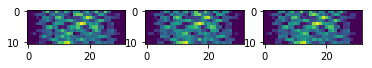

INFO:root:calculate_gram: raster_scan, single thread


./data/doga_grams/rmeta/1009_32_0.125.npy


INFO:root:calculate_gram: raster_scan, single thread
INFO:root:calculate_gram: raster_scan, single thread


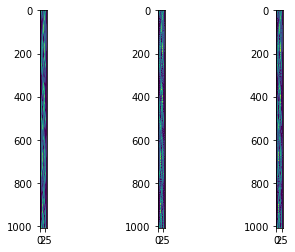

In [9]:
def grams():
    np.random.seed(0)
    pool=None
    for angle in num_angles:
        for pix in pixel_fractions:
            for gap in gap_fractions:
                num_steps = int(gap / probe_width)
                file = './data/doga_grams/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap)
                if not os.path.exists(file):
                    print(file)
                    procedure_raster = raster_scan(angle, num_steps, width_fraction=gap)
                    procedure_meta = raster_scan(angle, num_steps, width_fraction=gap, nmeta=0, random=False)
                    procedure_rmeta = raster_scan(angle, num_steps, width_fraction=gap, nmeta=0, random=True)

                    chunk = int(angle)
                    gram_raster, prb0 = calculate_gram(procedure_raster, angle*num_steps, phantom, pool=pool, chunksize=chunk)
                    gram_meta, prb1  = calculate_gram(procedure_meta, angle*num_steps, phantom, pool=pool, chunksize=chunk)
                    gram_rmeta, prb2 = calculate_gram(procedure_rmeta, angle*num_steps, phantom, pool=pool, chunksize=chunk)

                    gram_raster = -np.log(gram_raster)
                    gram_meta = -np.log(gram_meta)
                    gram_rmeta = -np.log(gram_rmeta)

                    np.save('./data/doga_grams/raster/{}_{}_{}.npy'.format(angle, num_steps, gap), [gram_raster, prb0])
                    np.save('./data/doga_grams/meta/{}_{}_{}.npy'.format(angle, num_steps, gap), [gram_meta, prb1])
                    np.save('./data/doga_grams/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap), [gram_rmeta, prb2])

                    plt.figure()
                    plt.subplot(1,3,1)
                    plt.imshow(gram_raster.reshape(angle, num_steps))
                    plt.subplot(1,3,2)
                    plt.imshow(gram_meta.reshape(angle, num_steps))
                    plt.subplot(1,3,3)
                    plt.imshow(gram_rmeta.reshape(angle, num_steps))
                    plt.show()
    
#                 print(gram_raster)
                
grams()
# textmewhendone('Fi', '8156440572', 'daniel.j.ching@gmail.com', 'xdvspvcaynshkmwu', grams)

In [10]:
def plot_grams():
    np.random.seed(0)
    pool=None
    for angle in num_angles:
        for pix in pixel_fractions:
            for gap in gap_fractions:
                num_steps = int(gap / probe_width)

                gram_raster, prb0 = np.load('./data/doga_grams/raster/{}_{}_{}.npy'.format(angle, num_steps, gap))
                gram_meta, prb1 = np.load('./data/doga_grams/meta/{}_{}_{}.npy'.format(angle, num_steps, gap))
                gram_rmeta, prb2 = np.load('./data/doga_grams/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap))

    #             fig = plt.figure(figsize=(3 * 8.85/2.54, 8.85/2.54), dpi=400)
                plt.figure()
                plt.subplot(1,3,1)
                plt.imshow(gram_raster.reshape(angle, num_steps), interpolation='none')
                plt.subplot(1,3,2)
                plt.imshow(gram_meta.reshape(angle, num_steps), interpolation='none')
                plt.subplot(1,3,3)
                plt.imshow(gram_rmeta.reshape(angle, num_steps), interpolation='none')
                plt.suptitle("Grams for {} measures and {} steps".format(total_measures, num_steps))
                plt.show()

# plot_grams()

./data/doga_recons/rmeta/50/256_11_32_0.125.npy
[          ] 2.00%

/home/chingd/Documents/xdesign/xdesign/algorithms.py:227: RuntimeWarning: invalid value encountered in true_divide
  init += np.true_divide(update, sumdist * sy)


[##########] 100.00%
[##########] 100.00%
[##########] 100.00%
False


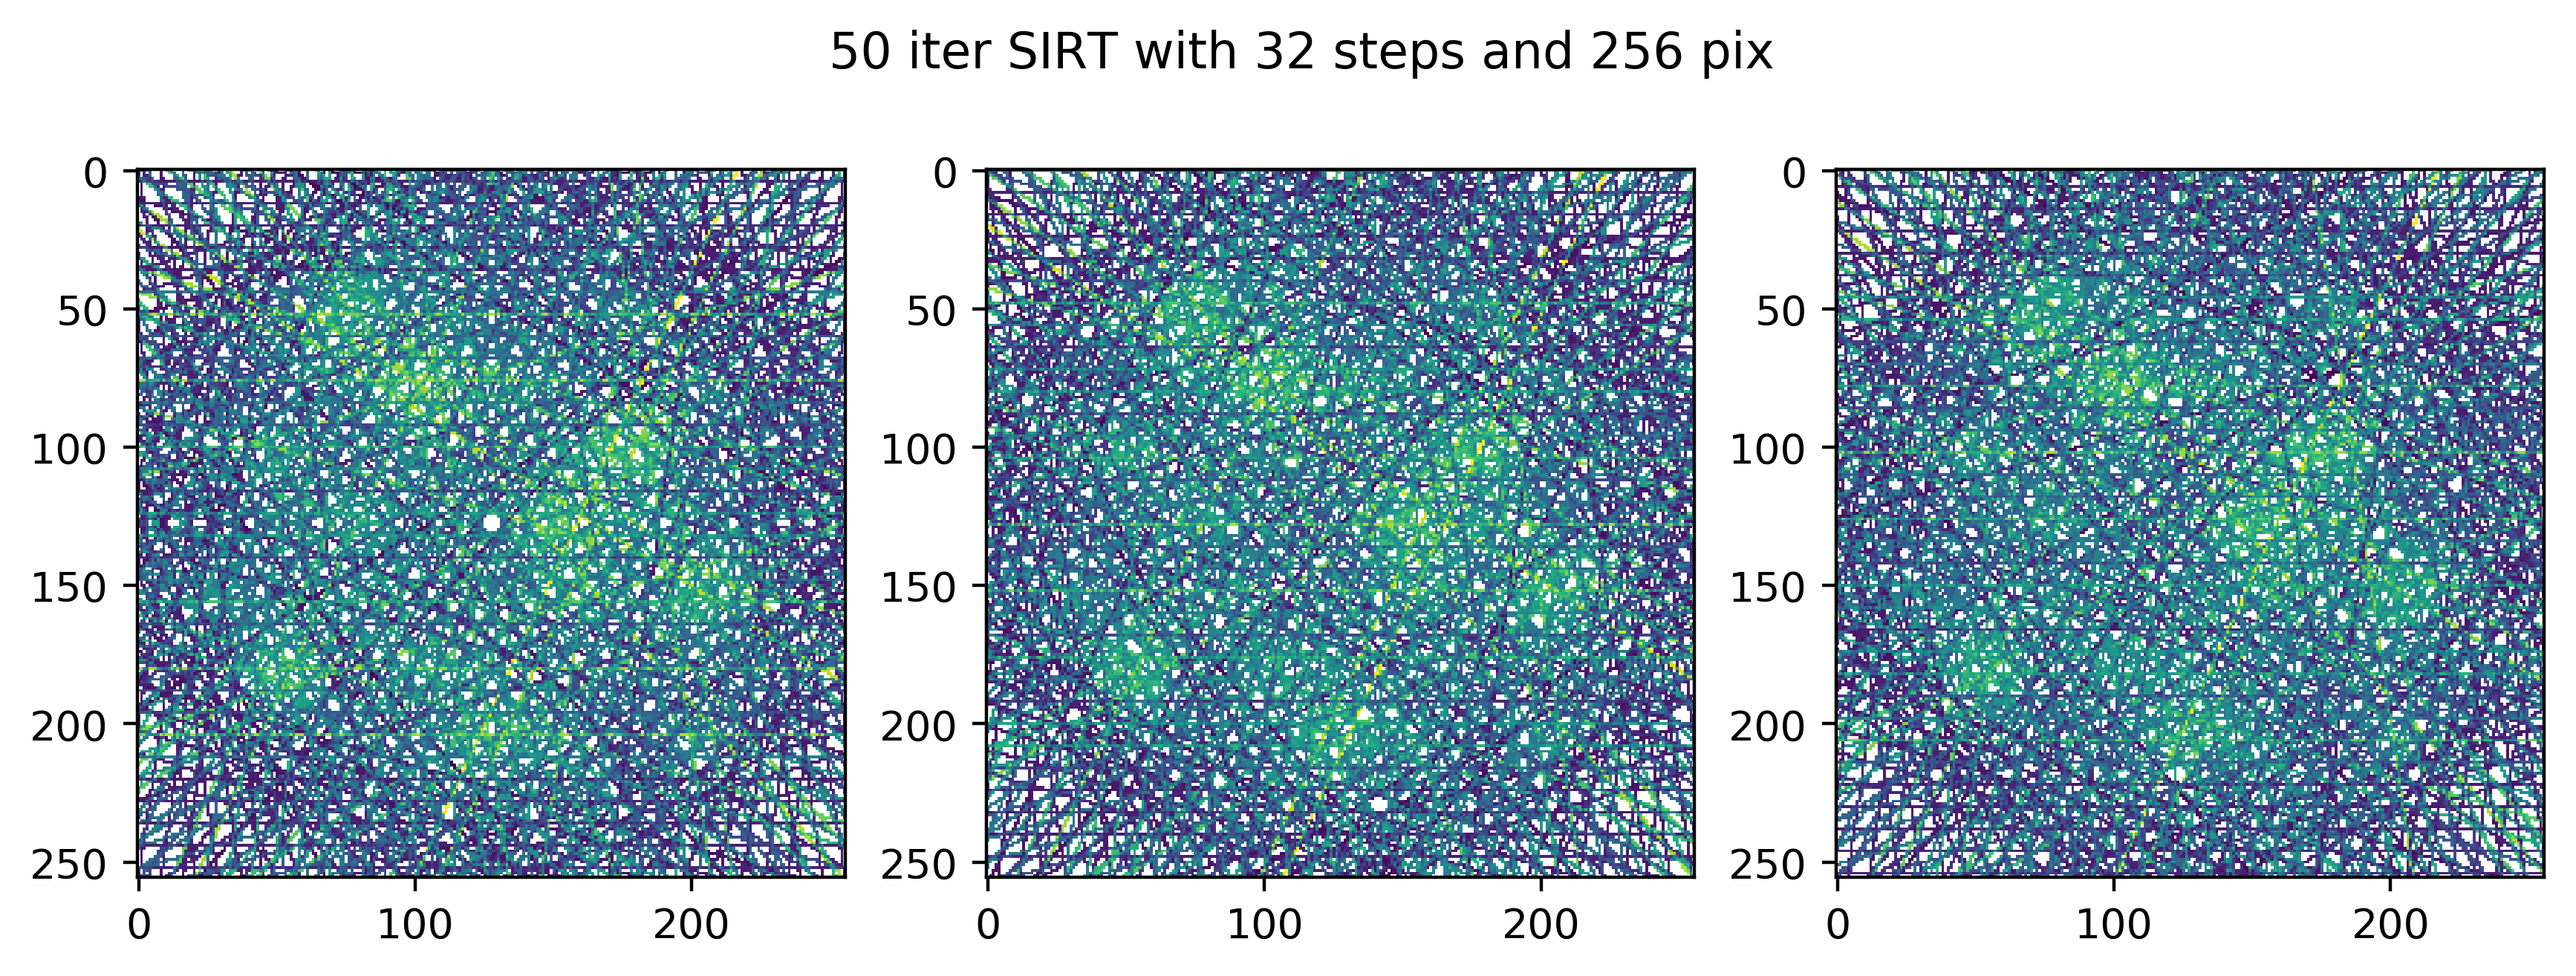

./data/doga_recons/rmeta/50/256_499_32_0.125.npy
[##########] 100.00%
[##########] 100.00%
[##########] 100.00%
False


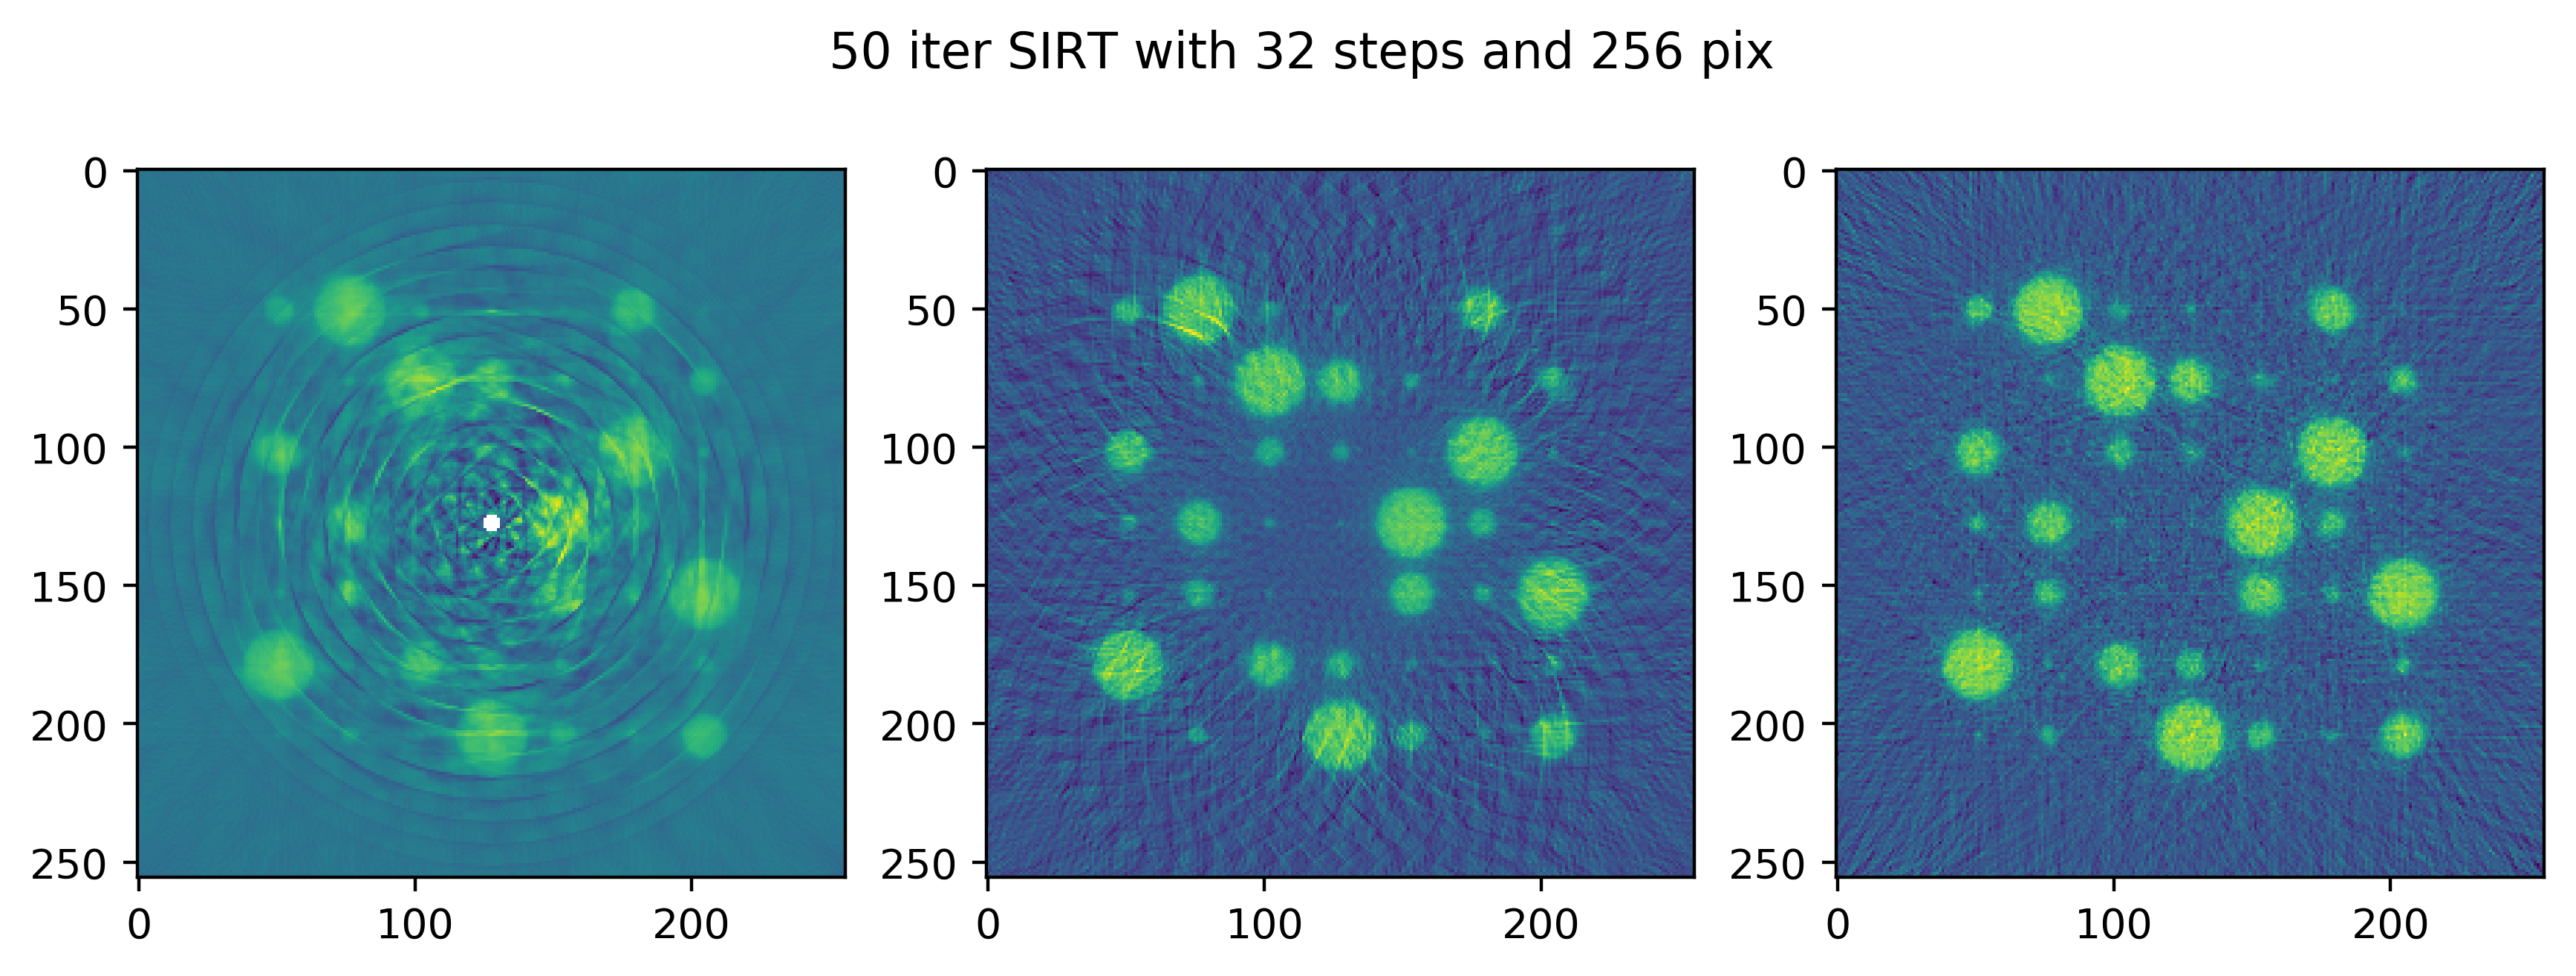

./data/doga_recons/rmeta/50/256_1009_32_0.125.npy
[##########] 100.00%
[##########] 100.00%
[##########] 100.00%
False


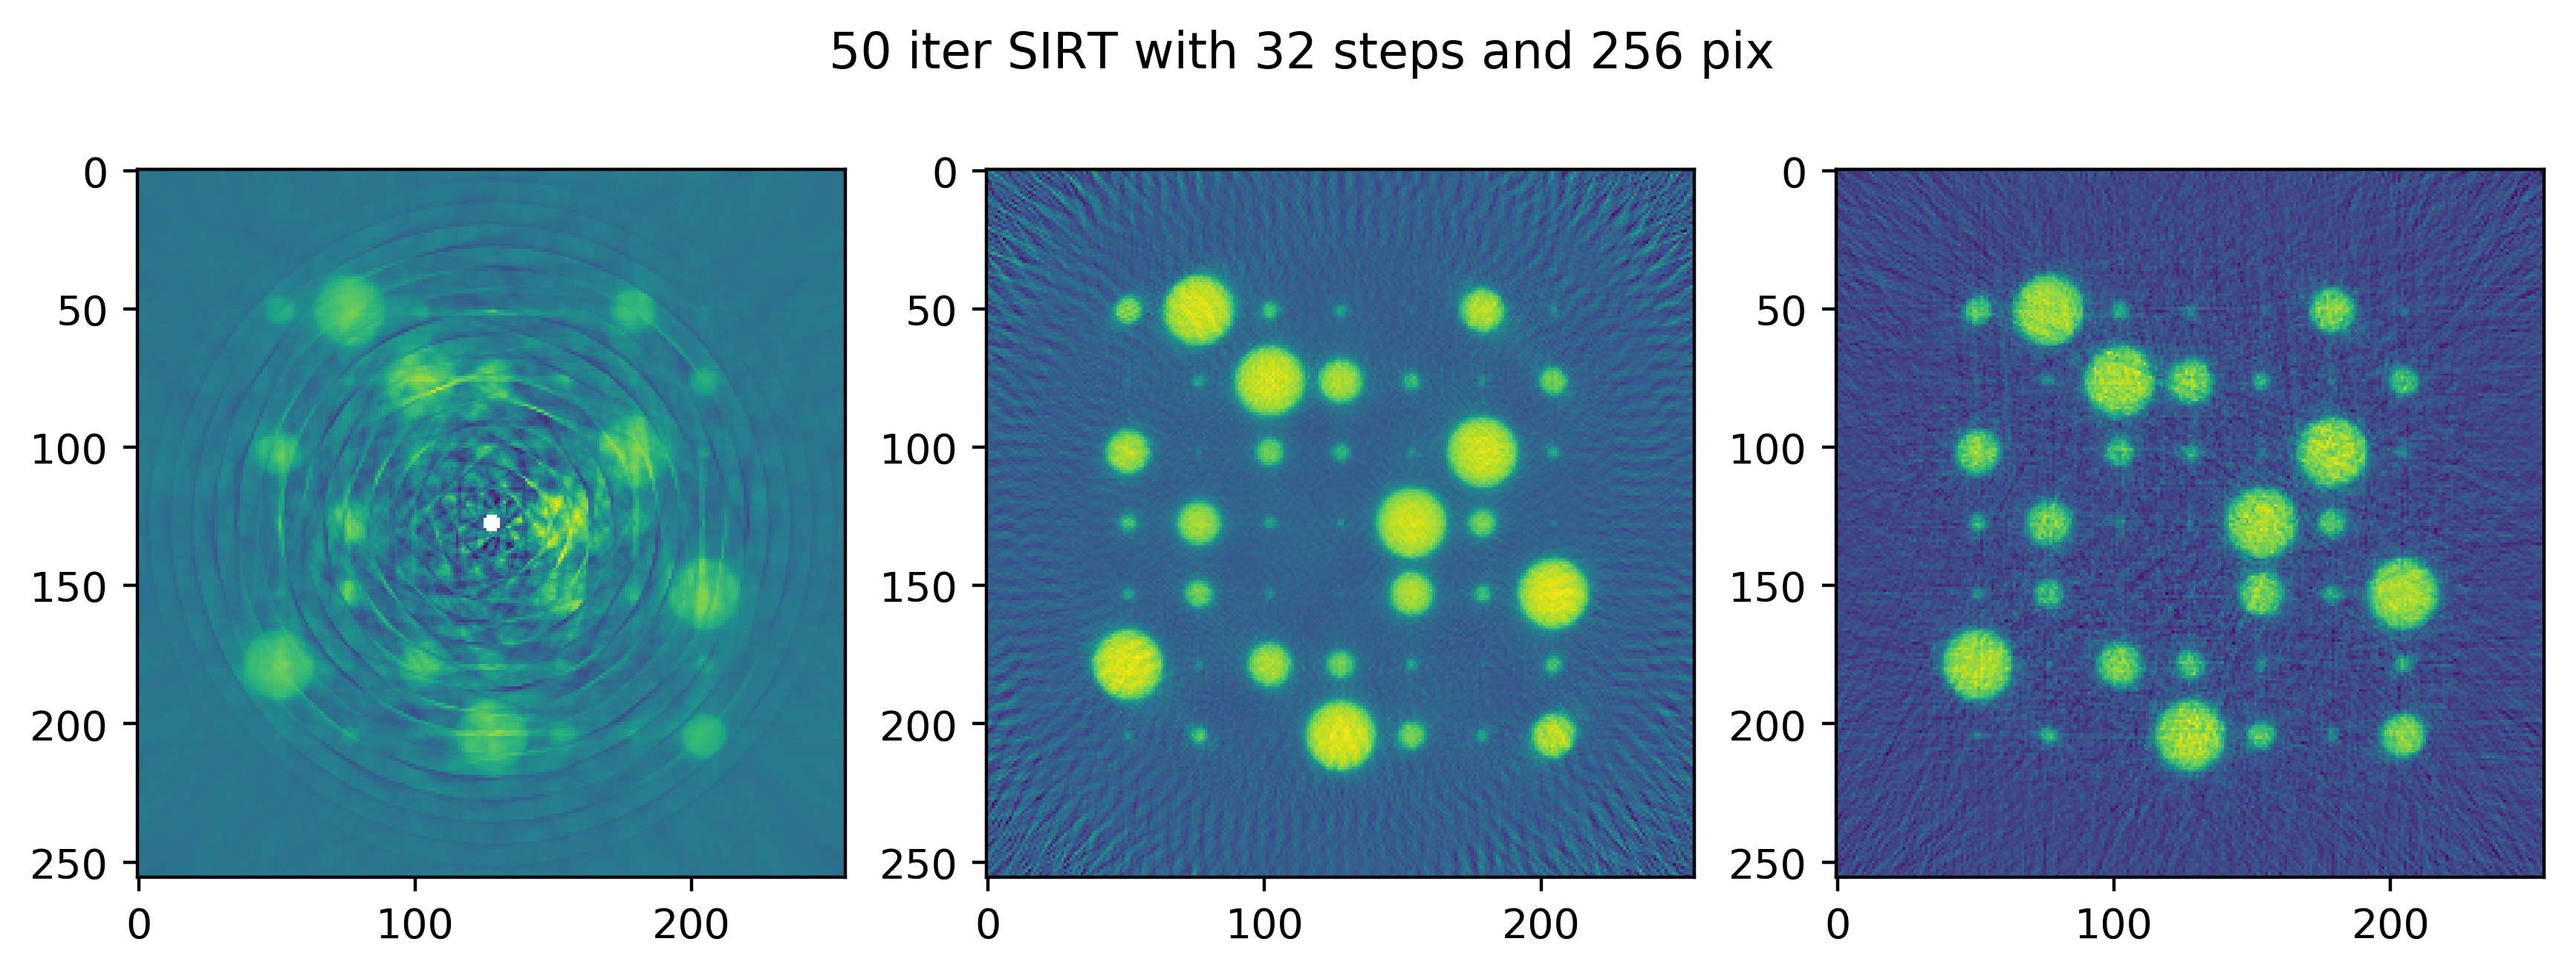

In [11]:
def makeit(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

niter = 50

def recons():
    np.random.seed(0)
    pool=None
    for angle in num_angles:
        for gap in gap_fractions:
            num_steps = int(gap / probe_width)
            file = './data/doga_recons/rmeta/{}/{}_{}_{}_{}.npy'.format(niter, size, angle, num_steps, gap)
            if not os.path.exists(file):
                print(file)
                gram_raster, prb0 = np.load('./data/doga_grams/raster/{}_{}_{}.npy'.format(angle, num_steps, gap))
                gram_meta, prb1 = np.load('./data/doga_grams/meta/{}_{}_{}.npy'.format(angle, num_steps, gap))
                gram_rmeta, prb2 = np.load('./data/doga_grams/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap))

#                 rec0 = np.load('./data/doga_recons/raster/{}_{}_{}.npy'.format(angle, num_steps, gap))
#                 rec1 = np.load('./data/doga_recons/meta/{}_{}_{}.npy'.format(angle, num_steps, gap))
#                 rec2 = np.load('./data/doga_recons/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap))

                rec0 = np.zeros((size, size))
                rec1 = np.zeros((size, size))
                rec2 = np.zeros((size, size))

                rec0 = sirt(prb0, gram_raster, rec0, niter=niter)
                rec1 = sirt(prb1, gram_meta, rec1, niter=niter)
                rec2 = sirt(prb2, gram_rmeta, rec2, niter=niter)

                makeit('./data/doga_recons/raster/{}'.format(niter))
                makeit('./data/doga_recons/meta/{}'.format(niter))
                makeit('./data/doga_recons/rmeta/{}'.format(niter))

                
                np.save('./data/doga_recons/raster/{}/{}_{}_{}_{}.npy'.format(niter, size, angle, num_steps, gap), rec0)
                np.save('./data/doga_recons/meta/{}/{}_{}_{}_{}.npy'.format(niter, size, angle, num_steps, gap), rec1)
                np.save('./data/doga_recons/rmeta/{}/{}_{}_{}_{}.npy'.format(niter, size, angle, num_steps, gap), rec2)

                print(np.all(rec0 == rec1))

                fig = plt.figure(figsize=(3 * 8.85/2.54, 8.85/2.54), dpi=400)
                plt.subplot(1,3,1)
                plt.imshow(rec0)
                plt.subplot(1,3,2)
                plt.imshow(rec1)
                plt.subplot(1,3,3)
                plt.imshow(rec2)
                plt.suptitle("{} iter SIRT with {} steps and {} pix".format(niter, num_steps, size))

#                 plt.savefig('./figures/{}_recon_comparison_{}.png'.format(angle, niter), format='png',
#                 transparent=True, bbox_inches=None, pad_inches=0,
#                 frameon=False)

                plt.show()

recons()
# textmewhendone('Fi', '8156440572', 'daniel.j.ching@gmail.com', 'xdvspvcaynshkmwu', recons)

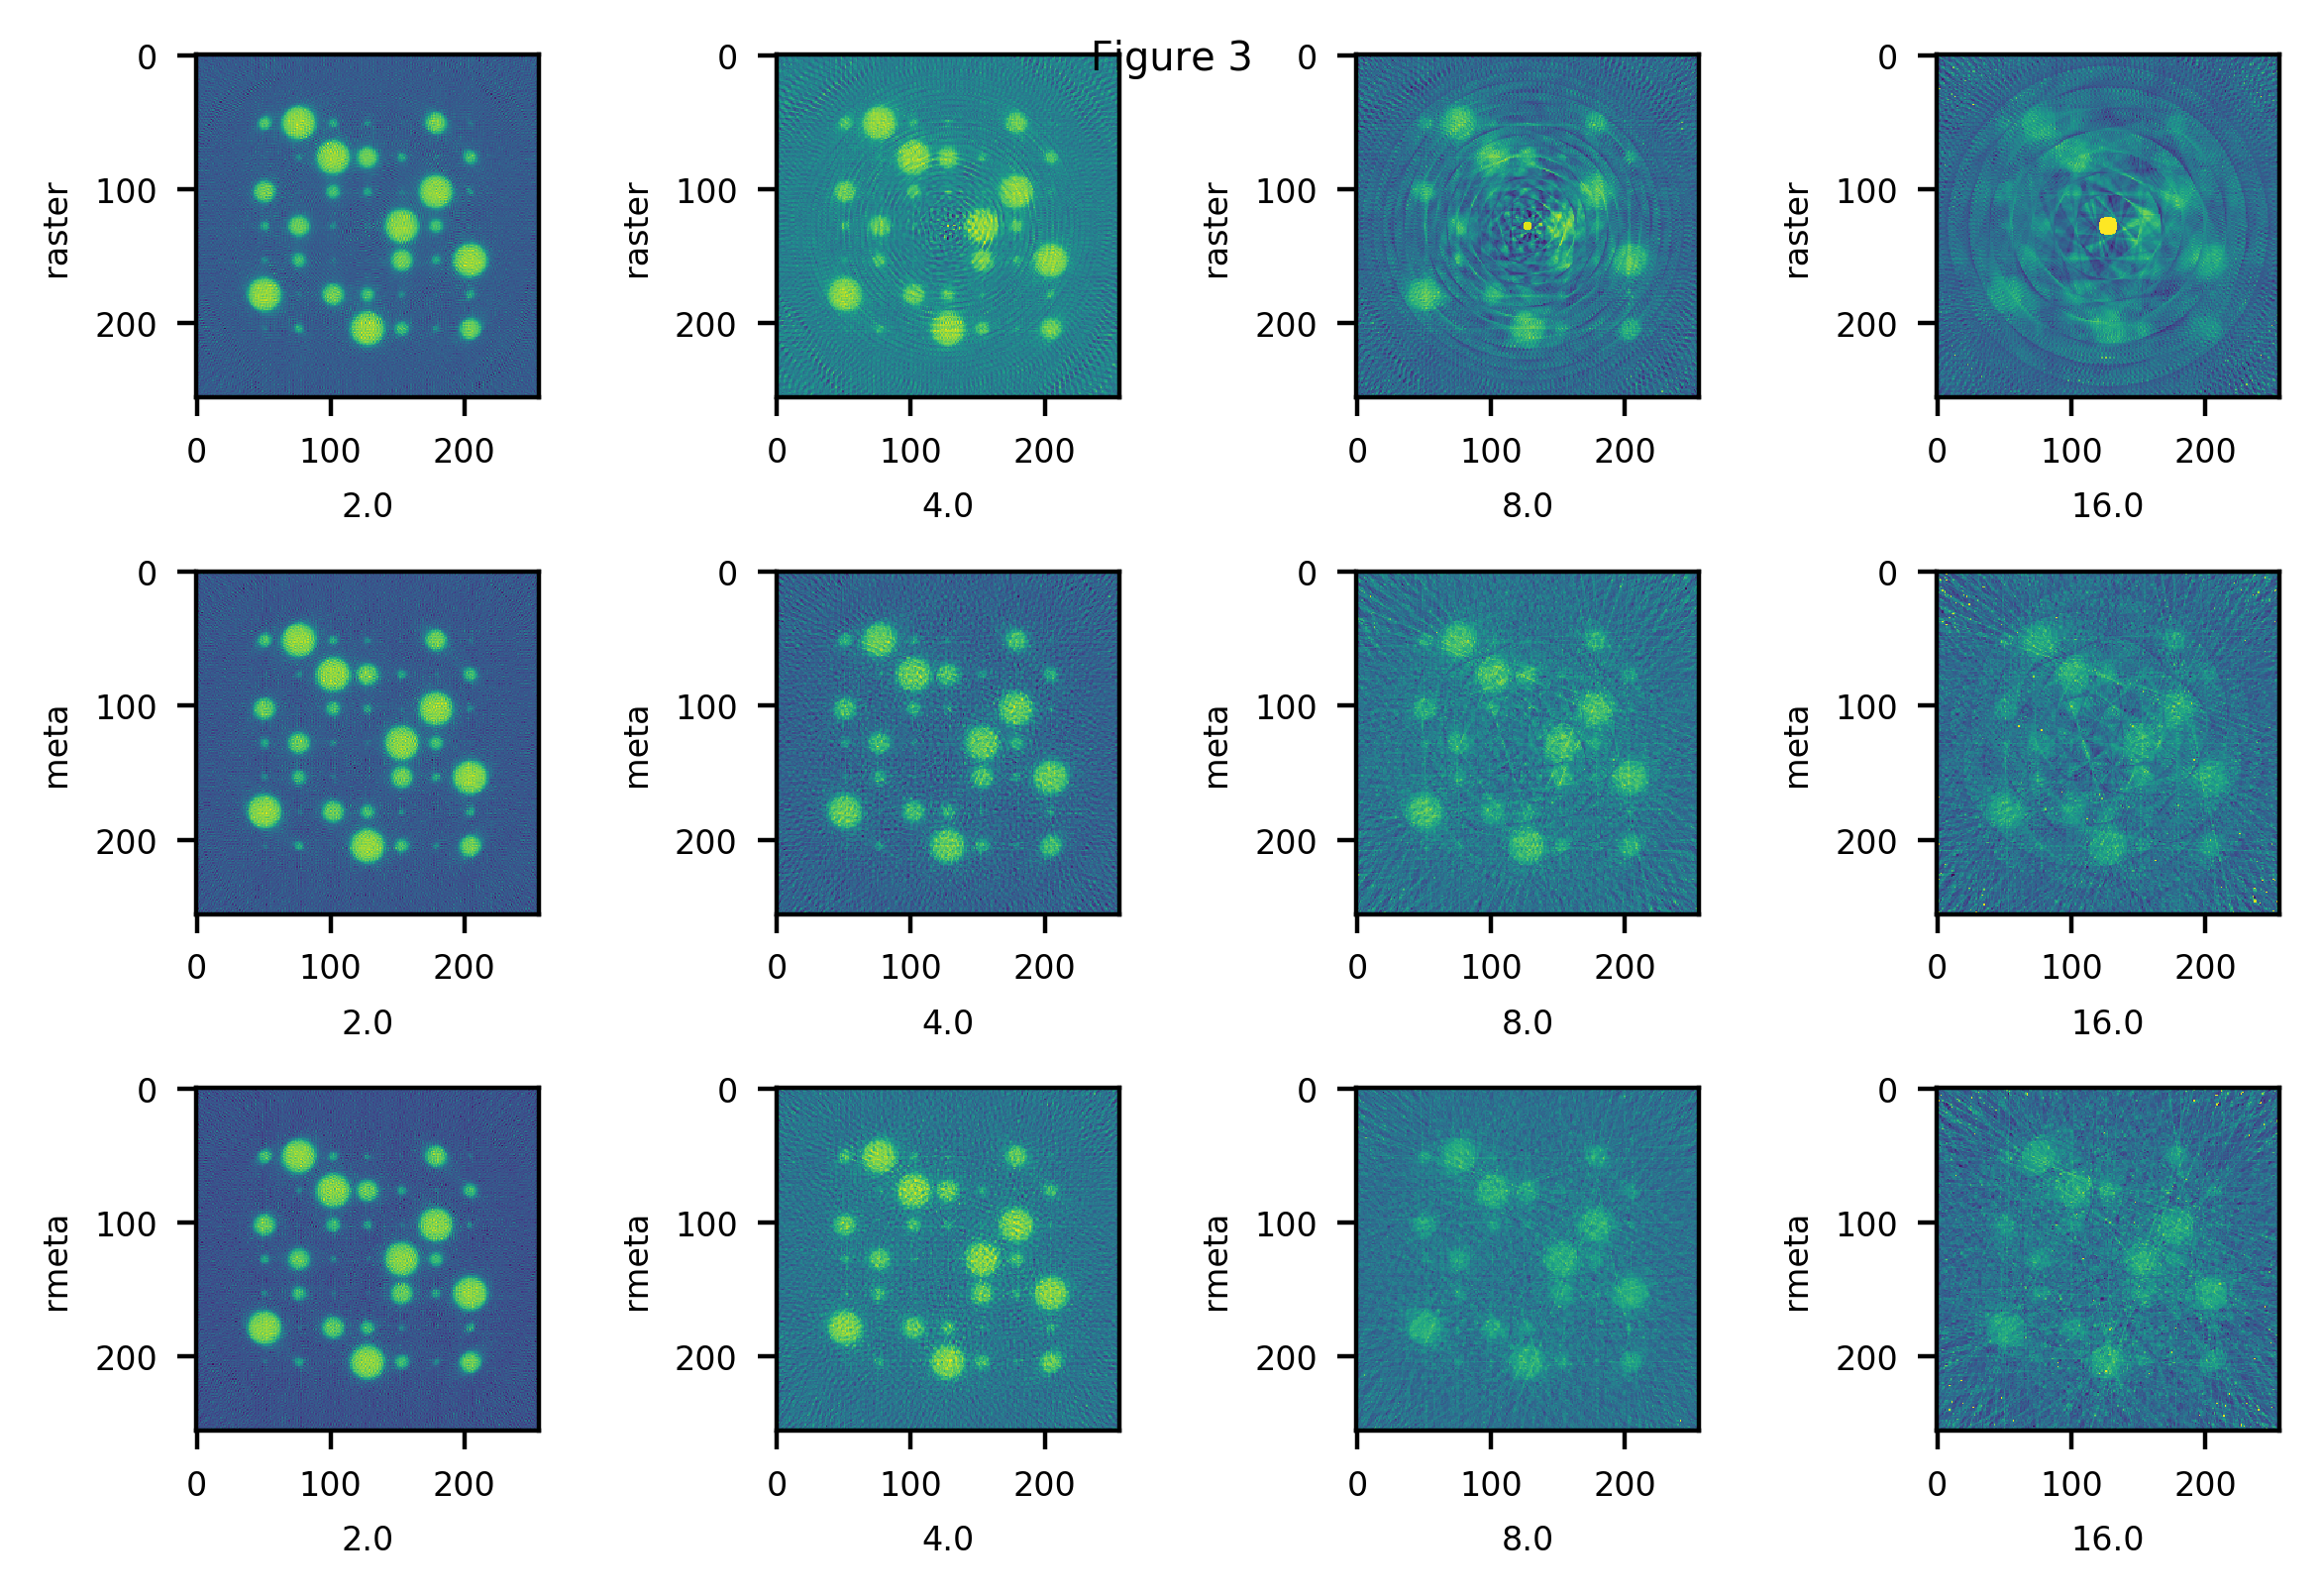

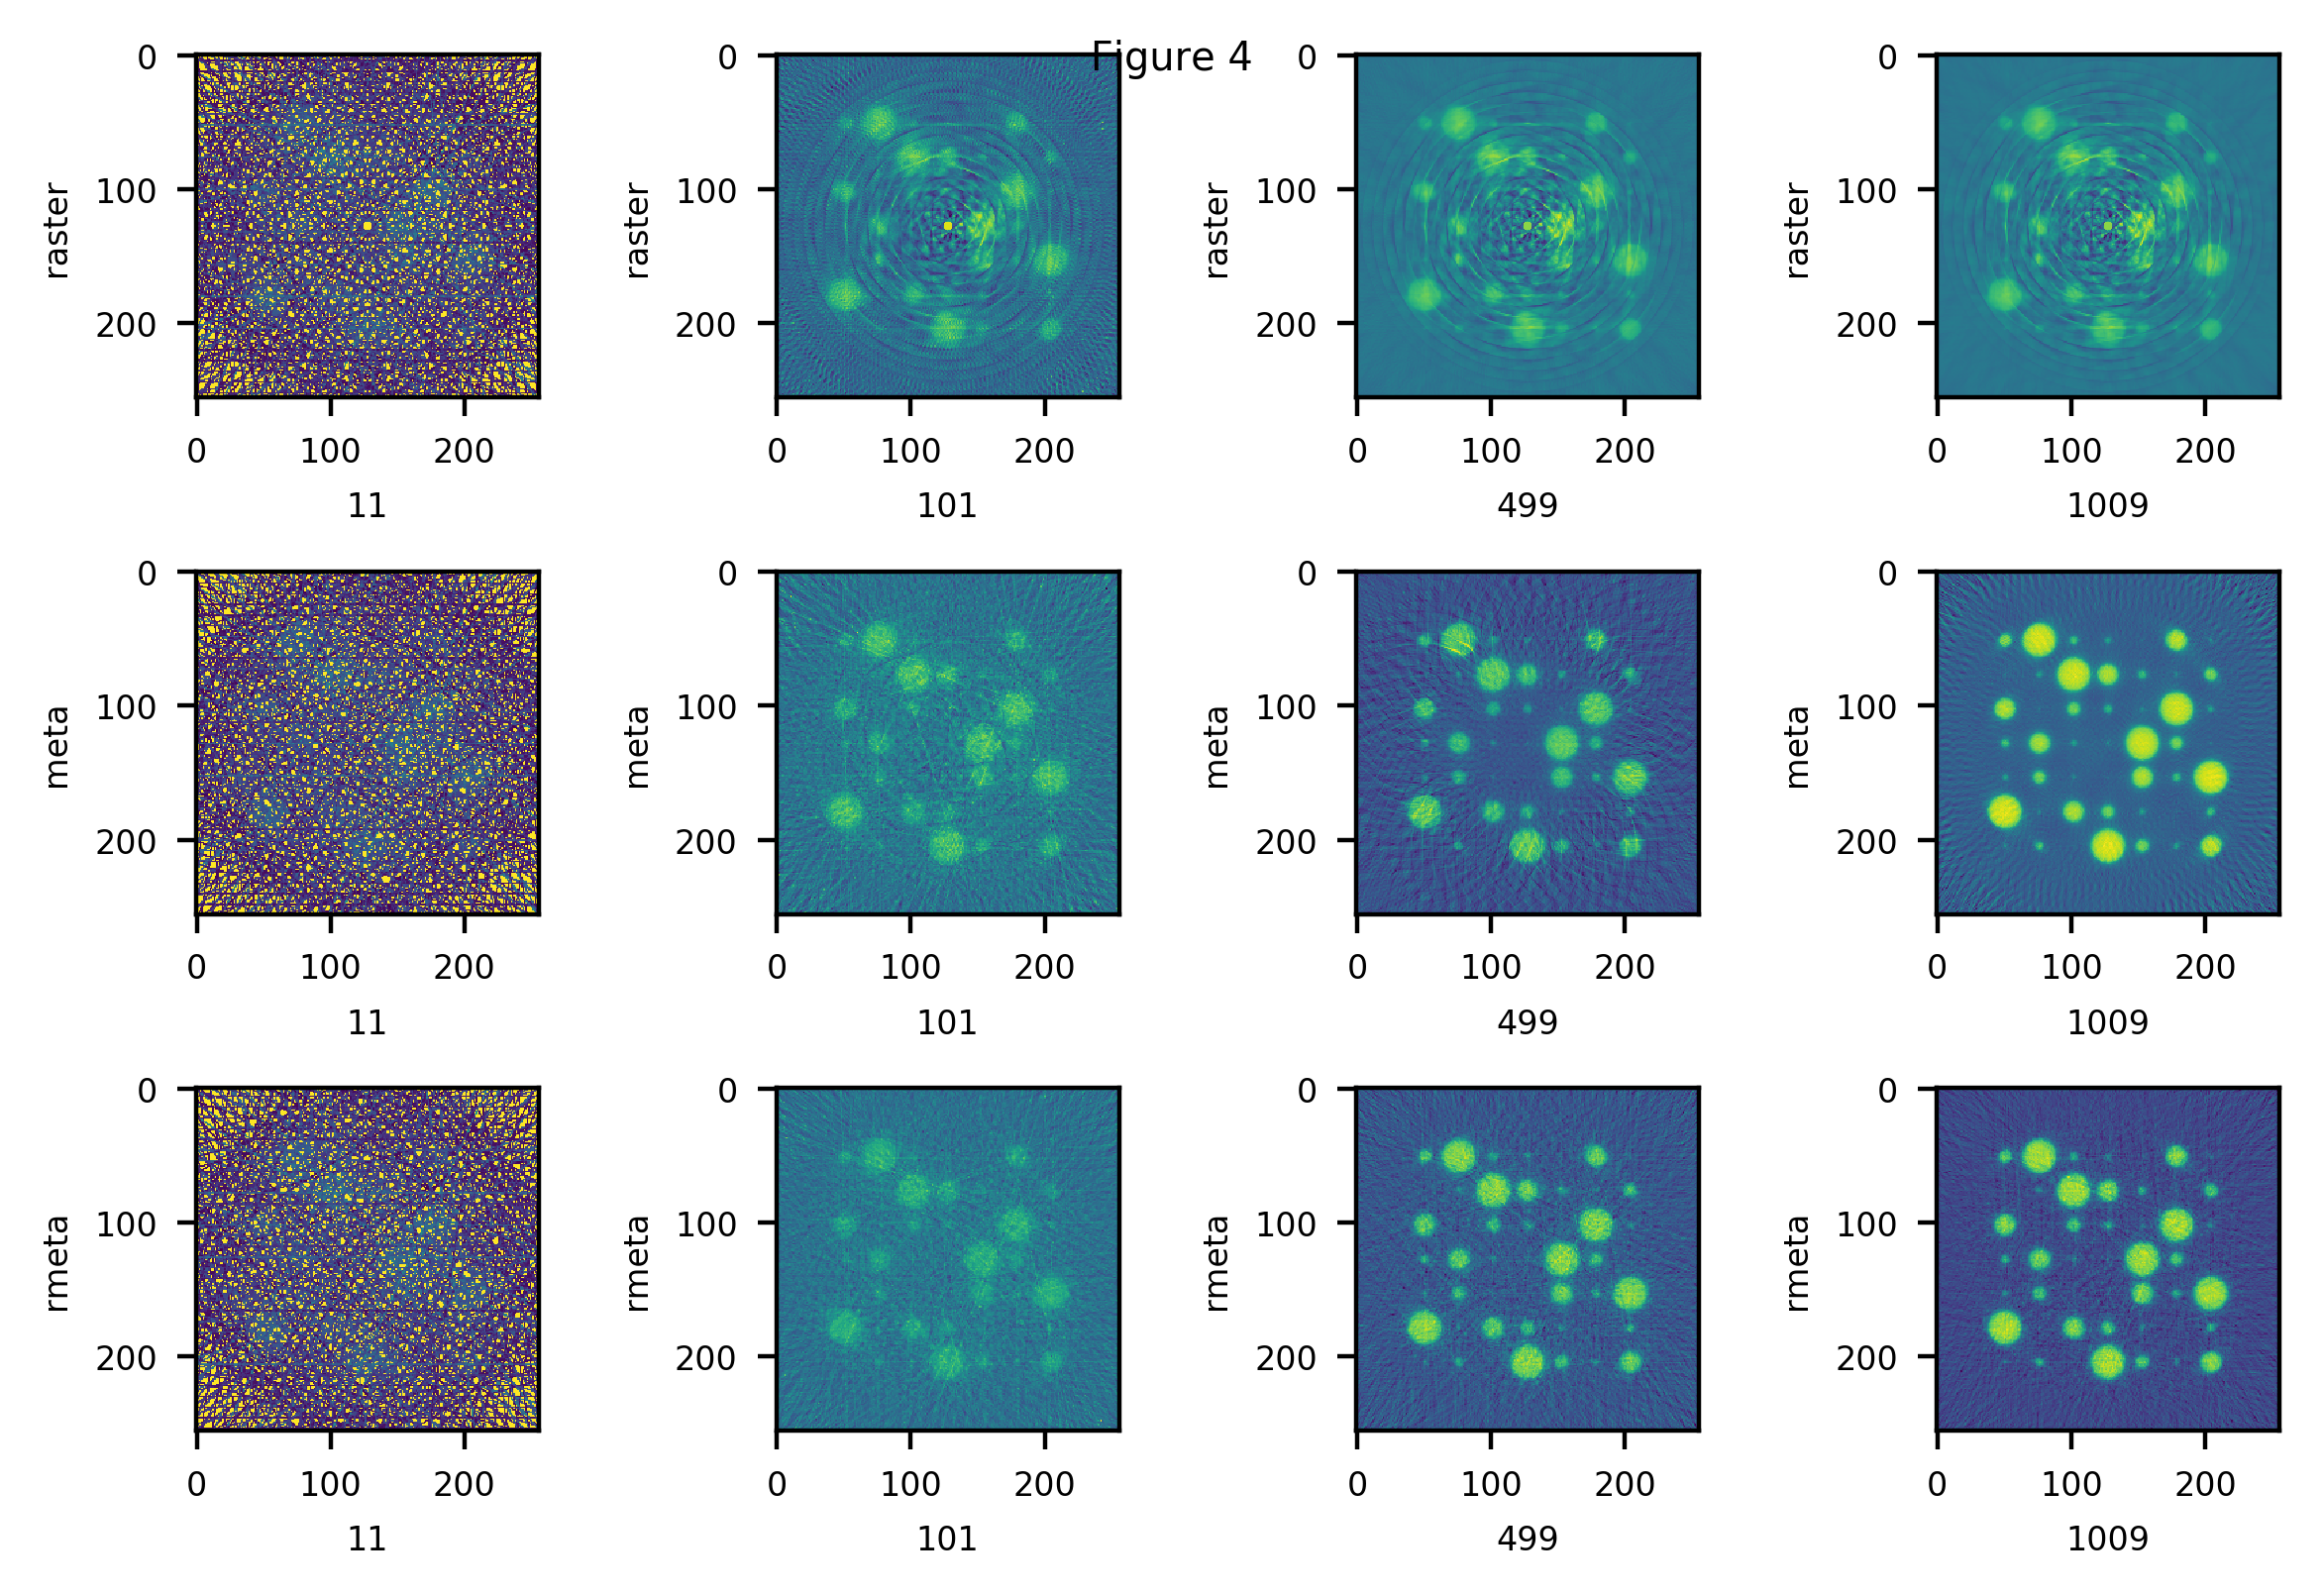

In [23]:
def plot_recons():
    
    fig3 = plt.figure(dpi=400)
    i = 1
    for method in ['raster', 'meta', 'rmeta']:
        for gap in [1./2, 1./4, 1./8, 1./16]:
            num_steps = int(gap / probe_width)
            
            plt.subplot(3,4,i)
            rec1 = np.load('./data/doga_recons/{}/{}/{}_{}_{}_{}.npy'.format(method, niter, size, 101, num_steps, gap))
            rec1[np.isnan(rec1)] = 1
            plt.imshow(rec1, interpolation=None)
            
            plt.ylabel(method)
            plt.xlabel(1/gap)
            i += 1

    plt.suptitle("Figure 3")
    plt.tight_layout()
    plt.show()
    
    
    
    fig4 = plt.figure(dpi=400)
    i = 1
    for method in ['raster', 'meta', 'rmeta']:
        for angle in [11, 101, 499, 1009]:
            gap = 1./8
            num_steps = int(gap / probe_width)
            
            plt.subplot(3,4,i)
            rec1 = np.load('./data/doga_recons/{}/{}/{}_{}_{}_{}.npy'.format(method, niter, size, angle, num_steps, gap))
            rec1[np.isnan(rec1)] = 1
            plt.imshow(rec1, interpolation=None)
            
            plt.ylabel(method)
            plt.xlabel(angle)
            i += 1
    plt.suptitle("Figure 4")
    plt.tight_layout()
    plt.show()
    
plot_recons()